<a href="https://colab.research.google.com/github/PengJuan-AI/TensorFlow_Study/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling up (Food 101 mini)

What we're going to cover:
* Downloading & preparing 10% of all Food101 classes (7500+ training images)
* Training a transfer learning feature extraction model
* Fine-tuning our feature extracction model (Food Vision mini) to beat the original Food101 paper with on 10% of the data.
* Evaluating Food Vision mini's predictions
  * Finding the most wrong predictions
* Making predictions with Food Vision mini on our own custom images.

**Serial experiment:**  
small dataset+small model ➡️ large dataset+small model ➡️ larger dataset+larger model ➡️ extra-large dataset+ extra-large model ➡️ everthing you got.



In this module, we're goingto use transfer learning feature extraction and this time, we scale it up for the classes in the Food101 (101 total classes of food)

Our goal is to beat the orginal Food101 paper with 10% of the training (leverage the power of transfer learning).

> The original paper used Random Forest and got results of an average accuracy of 50.76%.



In [ ]:
# Check the gpu
# If not, and you're in Google Colab, go to Runtime -> Change runtime type -> Hardware accelerator -> GPU
!nvidia-smi

Sun Aug 13 19:47:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# To avoid problem when saving the model
!pip uninstall -y tensorflow to remove the 2.12.x version

!pip install -U -q tensorflow==2.9.0
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Successfully uninstalled tensorflow-2.12.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 77.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 52.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-datasets 4.9.2 requires protobuf>=3.20, but you hav

## Create the helper function

In previous notebook, we used helper functions to help us. Let's download them.

In [ ]:
# get the helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-08-14 22:30:02--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-14 22:30:03 (88.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir


## 101 Food Claases: working with less data

In the original [Food101](https://www.kaggle.com/dansbecker/food-101) dataset there's 1000 images per class (750 of each class in the training set and 250 of each class in the test set), totalling 101,000 imags.

We could start modelling straight away on this large dataset but in the spirit of continually experimenting, we're going to see how our previously working model's go with 10% of the training data.

The data we're dowloading comes from the original Food101 dataset but has been preprocessed using [image_data_modification](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb)


In [ ]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2023-08-14 22:30:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 173.194.202.128, 173.194.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  74.4MB/s    in 12s     

2023-08-14 22:30:16 (126 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/filet_mignon'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tuna_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/peking_duck'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/samosa'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/french_onion_soup'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/churros'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/lobster_bisque'.
There are 0 directories and 250 ima

We got 101 food classes. For each train class, we got 75 images. For each test class, we got 250.

In [ ]:
# Set up the data input
IMG_SIZE = (224, 224)
train_data_10_pct = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                        label_mode='categorical',
                                                                        image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                       label_mode='categorical',
                                                                       image_size=IMG_SIZE,
                                                                       shuffle=False) # when we test the model, we want it to test in order in the test_dir

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a larger model with transfer learning on 10% of 101 food classes

Steps (using feature extraction model):
* Create a `ModelCheckpoint` callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layer) Functional `EfficientNetB0` backboned model (create our own output layer)
* Compile our model
* Feature extraction for 5 full passes (5 epochs on the tarin dataset and validate on 15% of the test data, to save epoch time)

In [ ]:
# Create a checkpoint callback
checkpoint_path = "101_classes_10_pct_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True) # Watch the point reaching the best val_accuracy and save the weights only

### Create a data augmentation and put it right into model layer

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # rescaling inputs of images between 0 and 1 is reuiqred for models like Resnet
], name="data_augmentation")

In [ ]:
# Setip the base model and freeze its layer (feature extractor)
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # we want to include our own output layer (101 classes)
base_model.trainable = False

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
from keras.layers.serialization import activation
from keras.layers import Input
# Setup model architecture
inputs = layers.Input(shape=(224, 224, 3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False) # this will put the base model in inference mode so weights stay frozen
x = layers.GlobalAveragePooling2D(name='global_avg_pool_layer')(x) # 2D beacause we're working on 2-dimension images
outputs = layers.Dense(len(train_data_10_pct.class_names), activation='softmax', name='output_layer')(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

### Compile the model

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


### Fit the model

In [ ]:
EPOCHS = 5

In [ ]:
history_10_pct = model.fit(train_data_10_pct,
                           epochs=EPOCHS,
                           steps_per_epoch=len(train_data_10_pct),
                           validation_data=test_data,
                           validation_steps=int(0.15*len(test_data)),
                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 102s 370ms/step - loss: 3.3793 - accuracy: 0.2708 - val_loss: 2.4306 - val_accuracy: 0.4897
Epoch 2/5
237/237 [==============================] - 71s 296ms/step - loss: 2.2144 - accuracy: 0.4917 - val_loss: 2.0484 - val_accuracy: 0.5175
Epoch 3/5
237/237 [==============================] - 64s 269ms/step - loss: 1.8122 - accuracy: 0.5702 - val_loss: 1.8758 - val_accuracy: 0.5426
Epoch 4/5
237/237 [==============================] - 61s 254ms/step - loss: 1.6051 - accuracy: 0.6108 - val_loss: 1.8233 - val_accuracy: 0.5395
Epoch 5/5
237/237 [==============================] - 58s 244ms/step - loss: 1.4477 - accuracy: 0.6425 - val_loss: 1.7495 - val_accuracy: 0.5498


In [ ]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 68s 86ms/step - loss: 1.5864 - accuracy: 0.5835


[1.5863829851150513, 0.583524763584137]

No doubts! The results is exciting. We reach an accuracy of 57.9% with 10% of total data in 5 minutes.

Now let's check the loss curves

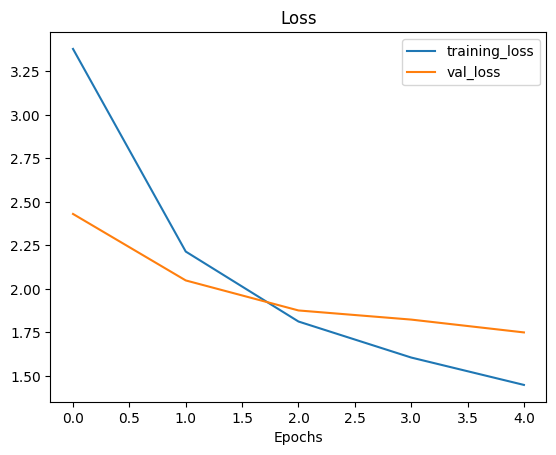

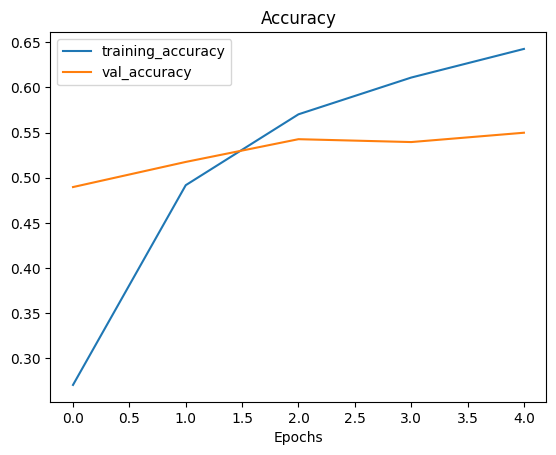

In [ ]:
plot_loss_curves(history_10_pct)

> What do these curves suggest?

The curves should be similar and closer, if not, there may be overfitting or underfitting.

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Freeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile model with lower learning rate (we would want to fine-tuning in smaller steps)
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [ ]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [ ]:
# Check trainable layers in base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# Fine-tune for 5 more epochs
# The first 5 epochs are feature extraction, and then we unfreeze some layers to fine-tune for 5 more epochs
fine_tune_epochs=10

# Fine tune our model
history_10_pct_fine_tune = model.fit(train_data_10_pct,
                                     epochs=fine_tune_epochs,
                                     validation_data=test_data,
                                     validation_steps=int(0.15*len(test_data)),
                                     initial_epoch=history_10_pct.epoch[-1]) # it will start fitting from the last epochs of last fitting
                                     # The total epochs are before_fine_tune + after_fine_tune


Epoch 5/10
237/237 [==============================] - 64s 235ms/step - loss: 1.2091 - accuracy: 0.6821 - val_loss: 1.6970 - val_accuracy: 0.5591
Epoch 6/10
237/237 [==============================] - 54s 225ms/step - loss: 1.0884 - accuracy: 0.7093 - val_loss: 1.6719 - val_accuracy: 0.5622
Epoch 7/10
237/237 [==============================] - 53s 220ms/step - loss: 1.0148 - accuracy: 0.7295 - val_loss: 1.6953 - val_accuracy: 0.5575
Epoch 8/10
237/237 [==============================] - 50s 210ms/step - loss: 0.9378 - accuracy: 0.7490 - val_loss: 1.6686 - val_accuracy: 0.5628
Epoch 9/10
237/237 [==============================] - 48s 201ms/step - loss: 0.8865 - accuracy: 0.7632 - val_loss: 1.6719 - val_accuracy: 0.5588
Epoch 10/10
237/237 [==============================] - 47s 197ms/step - loss: 0.8375 - accuracy: 0.7774 - val_loss: 1.6806 - val_accuracy: 0.5588


So if we did not get a better result after fine-tuning, we can use checkpoint to revert the model to previous best weights.

In [ ]:
# Evalaute it on the whole test data
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 63s 80ms/step - loss: 1.4927 - accuracy: 0.6044


[1.4926738739013672, 0.6044356226921082]

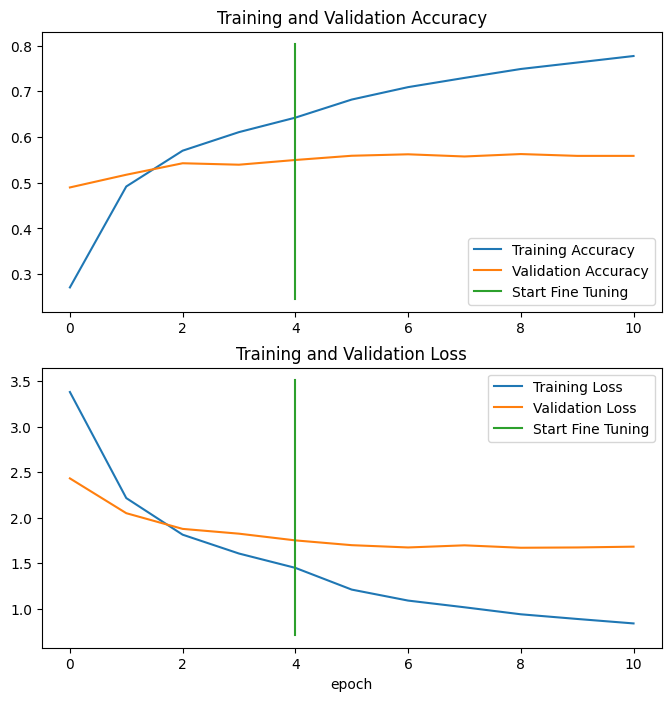

In [ ]:
# Compare histories of feature extraction and fine-tuning models
compare_historys(original_history=history_10_pct,
                 new_history=history_10_pct_fine_tune,
                 )

It seems after fine-tuning the model got better accuracy on training data while the val_accuracy did not change much. It means that the model is overfitting.

## Save and load our trained model

To use our model in an external application, we'll need to save it and export it somewhere else.

So when saving the model, I ran into this problem:  
```
Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.
```
and I searched for solutions, it shows that this problem haven't been solved yet. And the best solution at the moment is to downgrade the Tensorflow to 2.9.0 verision. (and it works)

Discussions about this bug:
* [use EfficientNetB0](https://discuss.tensorflow.org/t/using-efficientnetb0-and-save-model-will-result-unable-to-serialize-2-0896919-2-1128857-2-1081853-to-json-unrecognized-type-class-tensorflow-python-framework-ops-eagertensor/12518)
* [keras team issue](https://github.com/keras-team/keras/issues/17199)

In [ ]:
model.save("model/101_food_classes_10_pct_data_fine_tuned_last_5")
# model.save("model/101_food_classes_10_pct_data_fine_tuned_last_5_v2" )
# tf.keras.models.save_model(model, "model/101_food_classes_10_pct_data_fine_tuned_last_5_v2")

In [ ]:
# Load and evaluate saved model
# saved_model = tf.saved_model.load("model/101_food_classes_10_pct_data_fine_tuned_last_5")
# loaded_model = tf.keras.models.load_model("model/101_food_classes_10_pct_data_fine_tuned_last_5")
loaded_model = tf.keras.models.load_model("model/101_food_classes_10_pct_data_fine_tuned_last_5")


In [ ]:
# If everything is fine, we can evaluate the loaded model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 67s 82ms/step - loss: 1.4927 - accuracy: 0.6044


[1.4926738739013672, 0.6044356226921082]

In [ ]:
# compare loaded_model_results with original model
fine_tuning_results

[1.4926738739013672, 0.6044356226921082]

issues: Unable to create a Keras model from SavedModel at model/101_food_classes_10_pct_data_fine_tuned_last_5. This SavedModel was exported with `tf.saved_model.save`, and lacks the Keras metadata file. Please save your Keras model by calling `model.save` or `tf.keras.models.save_model`. Note that you can still load this SavedModel with `tf.saved_model.load`.

And if you want to save the model into your google drive:
```
!mv /content/model/101_food_classes_10_pct_data_fine_tuned_last_5 /content/drive/MyDrive/tf_models
```

## Evaluating the performance of the big model across all different classes

Let's make some predictions, visualize them and then find out which predictions were the "most" wrong.

We're going to use pretrained and saved model from: https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

In [ ]:
# import tensorflow  as tf

# Download pretrained model (one that was pretrained earlierso all predictions are similar)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2023-08-14 22:30:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 173.194.203.128, 142.250.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   170MB/s    in 0.3s    

2023-08-14 22:30:45 (170 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
# Load in saved model
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
# Evaluate loaded model (the one just being downloaded)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 93s 101ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

## Making predictions with out trained model

In [ ]:
# Make predictions with model
# because its a multi-classification problem and we use softmax as activation function in output layer
# So it actually outputs probabilities of predictions (an array)
# Note: the data you pass into a trained model, the test data should have the same format of train data
preds_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 102s 124ms/step


In [ ]:
len(preds_probs)

25250

In [ ]:
# shape of predictions
preds_probs.shape

(25250, 101)

So basically it has 25250 predications, and for each predictions, it give 101 predicted probs for each class.

In [ ]:
# We get one prediction prob per class
print(f"Number of predition probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction prob smaple 0 looks like: \n {preds_probs[0]}")
print(f"The class with the highest predicted prob by the model for sample 0: {preds_probs[0].argmax()}")

Number of predition probabilities for sample 0: 101
What prediction prob smaple 0 looks like: 
 [5.95422126e-02 3.57421368e-06 4.13770415e-02 1.06606324e-09
 8.16142531e-09 8.66396288e-09 8.09274070e-07 8.56529539e-07
 1.98591606e-05 8.09774235e-07 3.17277338e-09 9.86737973e-07
 2.85322894e-04 7.80490172e-10 7.42304197e-04 3.89164816e-05
 6.47405386e-06 2.49774143e-06 3.78911900e-05 2.06782616e-07
 1.55384460e-05 8.15073861e-07 2.62306344e-06 2.00106967e-07
 8.38279050e-07 5.42160706e-06 3.73909870e-06 1.31505775e-08
 2.77615804e-03 2.80519871e-05 6.85621337e-10 2.55748728e-05
 1.66889717e-04 7.64069696e-10 4.04530176e-04 1.31506805e-08
 1.79573726e-06 1.44482397e-06 2.30628941e-02 8.24670678e-07
 8.53659003e-07 1.71386728e-06 7.05256207e-06 1.84021616e-08
 2.85534497e-07 7.94839616e-06 2.06815457e-06 1.85251992e-07
 3.36197594e-08 3.15226032e-04 1.04109295e-05 8.54483289e-07
 8.47418368e-01 1.05554509e-05 4.40948213e-07 3.74041701e-05
 3.53062496e-05 3.24890570e-05 6.73149116e-05 1.28

In [ ]:
test_data.class_names[52]

'gyoza'

In [ ]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [ ]:
# how many pred classes do we have?
len(pred_classes)

25250

Now we've got a predictions array of all of our model's predictions, to evaluate them we need to compare them to the original test data labels.

In [ ]:
# Unravel our teat data batch to get test labels
# Cuz our test_data is bacthes right now -- we need to unbatch test data
y_label = []
for images, labels in test_data.unbatch():
  y_label.append(labels.numpy().argmax()) # currently test labels is like: [0, 0, 1, 0, ..., 0]


In [ ]:
y_label[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

So why all zeros?

Because when we create test_data, we set `shuffle=False`, which means the test data is in order as in the test folder.

Therefore, we can easily and  directly compare the true labels with predicted labels.

In [ ]:
len(y_label)

25250

## Evaluate our model's predictions

One way to check that our model's predictions array in the same order as our test labels array is to find the accuracy score.

In [ ]:
# Let's try sklearn accuracy score
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_label, y_pred=pred_classes)

sklearn_accuracy

0.6077623762376237

In [ ]:
results_downloaded_model

[1.8027204275131226, 0.6077623963356018]

So we can confirm at this stage that the order of `pred_classes` is tha same as orginal labels (`y_label`)

## Let's visualize it: making a confusion matrix

Use the `make_confusion_matrix` in `helper_function`

In [ ]:
# get a list of class_name
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
from helper_functions import make_confusion_matrix
make_confusion_matrix(y_true=y_label,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100))

### Make some changes on `make_confusion_matrix` function

So we need to make some changes to adjust labels on x-axis, making them vertical.

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Plot x-labels vertically (changed)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
make_confusion_matrix(y_true=y_label,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100))

## Make classification report

Scikit-learn has a helpful function for acquiring many different classification metrics per class (e.g. precision, recall and F1) called classification report.
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_label, pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The number above give a great class-byclass evaluation of our model's predictions but with so many classes, they're quite hard to understand.

How about we create a viusalization to get a better understanding?

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_label, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

Let's plot all of our classes F1-score

In [ ]:
# Create empty dictionary
class_f1_score = {}

# Loop through classification dict items
for key, val in classification_report_dict.items():
  if key == "accuracy": # stop at here
    break
  else:
    # Add class name and f1-score
    class_f1_score[class_names[int(key)]] = val['f1-score']

class_f1_score

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [ ]:
# Turn f1-score into dataframe for visualization
import pandas as pd
df_f1_score = pd.DataFrame(class_f1_score.values(), index=class_f1_score.keys(), columns=["f1-score"]).sort_values("f1-score", ascending=False)
df_f1_score

f1-score
edamame              0.937143
macarons             0.895397
pho                  0.866538
spaghetti_carbonara  0.847656
oysters              0.834008
...                       ...
huevos_rancheros     0.339833
chocolate_mousse     0.329159
pork_chop            0.308756
foie_gras            0.297491
apple_pie            0.240566

[101 rows x 1 columns]

<Axes: >

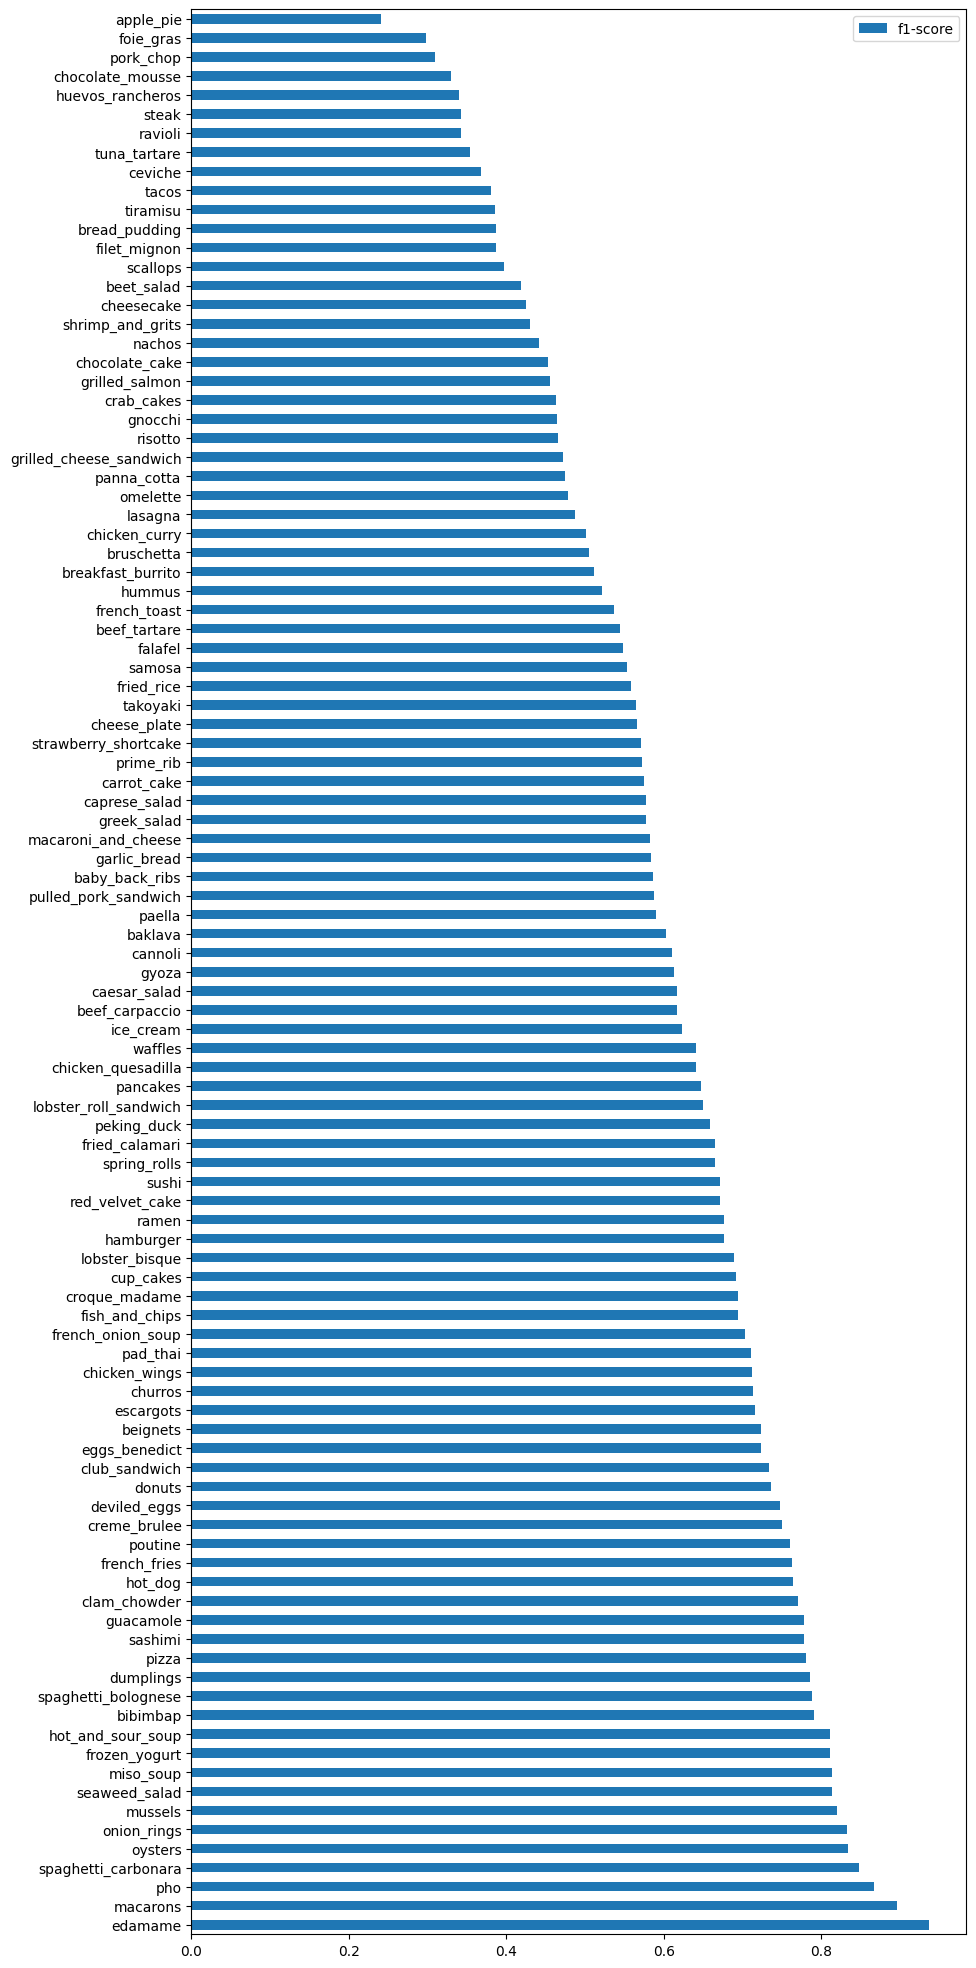

In [ ]:
df_f1_score.plot(kind='barh', figsize=(10, 25))

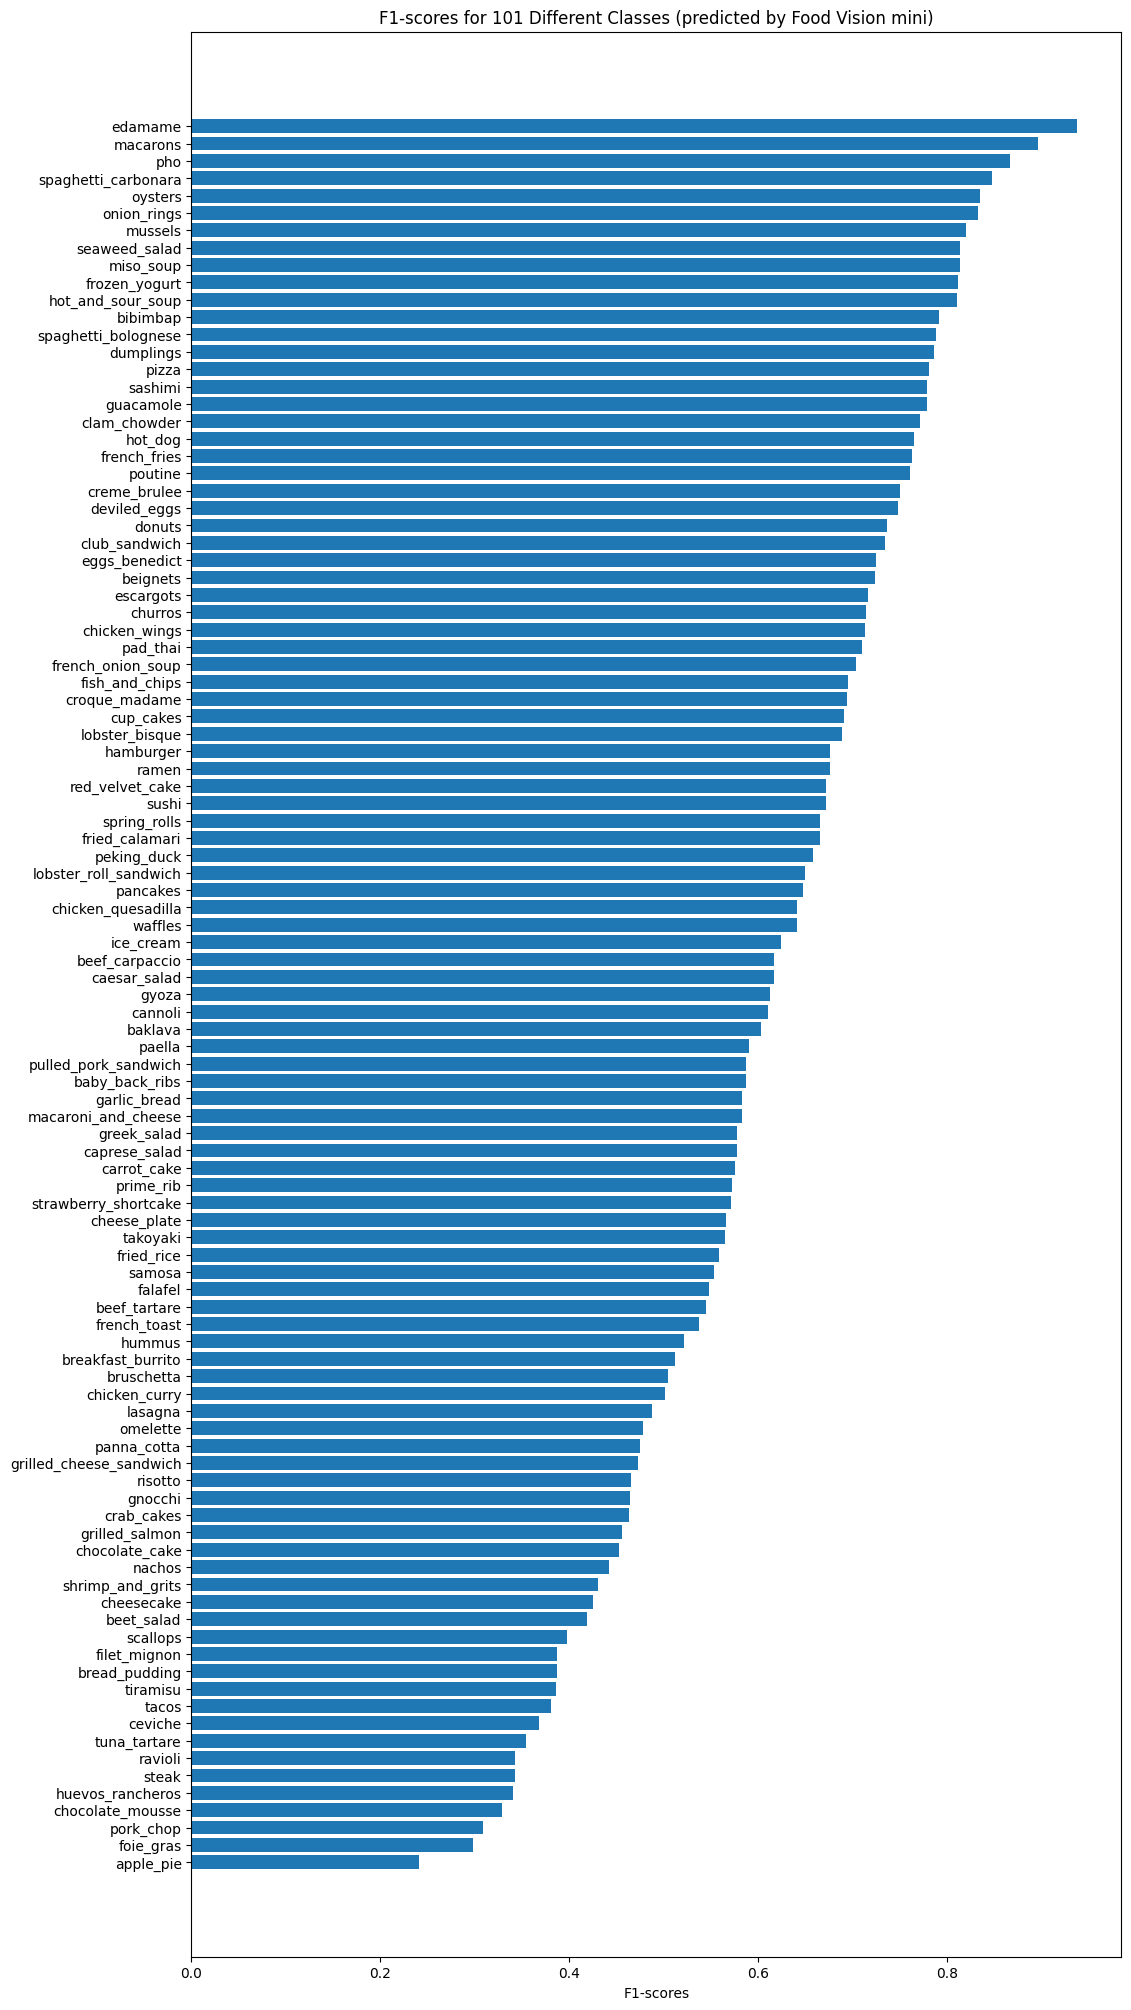

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores  = ax.barh(range(len(df_f1_score)), df_f1_score["f1-score"].values) # get f1-score valus
ax.set_yticks(range(len(df_f1_score)))
ax.set_yticklabels(df_f1_score.index)
ax.set_xlabel("F1-scores")
ax.set_title("F1-scores for 101 Different Classes (predicted by Food Vision mini)")
ax.invert_yaxis();

Great! Now we can make a presentation to show our model results.

**Exercise:** Try visualize some of the most poorly predicted classes (e.g. apple_pie, pork_chop), do you notice any trends among them? Why migh the model have trouble with them?

make a function -- plot images
* input: test_labels, pred_classes, class_name
* output: origin images vs. predicted class image

In [ ]:
def compare_true_and_pred(y_true, y_pred, classes, class_name):
  '''
  plot images of orginal class and predicted class
  '''



## Visualize predictions on custom images

Now, this is the real test, how does our model go on food images not even in our test dataset.

To visualize our model's prediction on our own images, we'll need a function to load and preprocess imahes, specifically it will need to:
* A target image filepath using `tf.io.read_file()`
* Turn the image into a tensor using `tf.io.decode_image()`
* Resize the image tensor to be the same size as the images our model has trained on using `tf.image.resize()`
* Scale the image to get all of the pixel values between 0&1 (if necessary)


> you can only use data with the same format/shape of the data used to train your model

**Links:**
* https://www.tensorflow.org/api_docs/python/tf/io/read_file
* https://www.tensorflow.org/api_docs/python/tf/io/decode_image

In [ ]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  '''
  Reads in an image from filename, turns it into a tensor and reshapes it into specified shape (img_shape, img_shape, 3).

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  '''
  # Read the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  # so if a user input a PNG image, we need to convert its color channels to 3
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, size=[img_shape, img_shape])

  # Scale Yes/no
  if scale:
    # rescale the image
    return img/255.
  else:
    return img # e.g EfficientNet does't need to rescale.


Now we have the function to read and repare target images, let's now yse it to visualize images.

Specifically, we'll write some codes to:
1. Load a few random images from the test dataset
2. Make a predictions on th loaded images
3. Plot the original image(s) along with the model's predictions, prediction probability and true label.

In [ ]:
# check the shape of our train data -- (None, 224, 224, 3)
train_data_10_pct

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

1/1 [==============================] - 0s 29ms/step


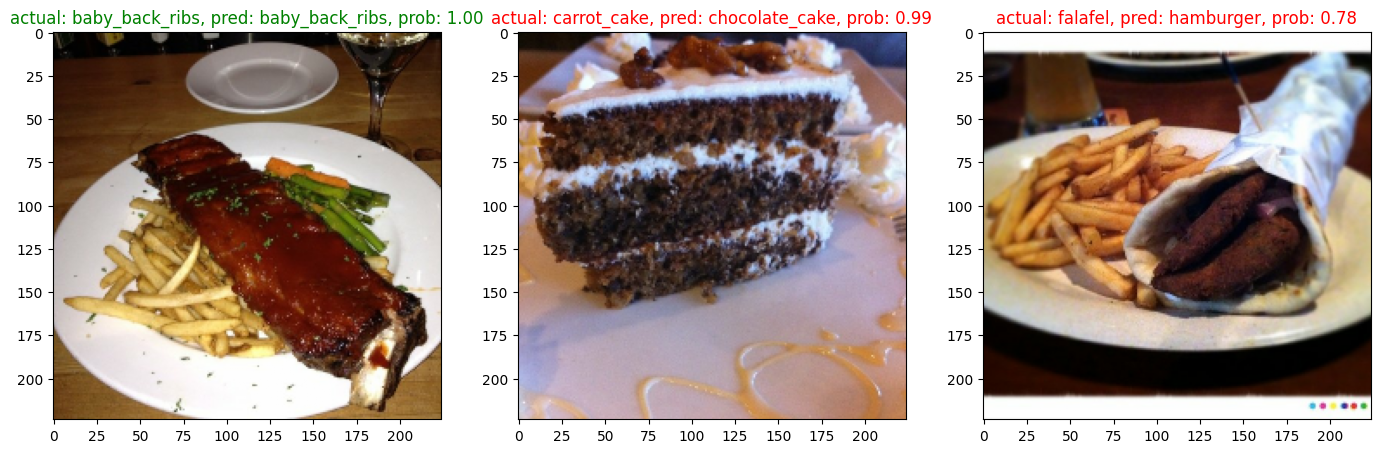

In [ ]:
# Make preds on a series of random images
import random
import os

plt.figure(figsize=(17, 10))
for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir+'/'+class_name))
  filepath = test_dir + class_name+'/'+filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # get predictions array
  pred_class = class_names[pred_prob.argmax()] # get the highest prob class name
  # print(pred_prob)
  # print(pred_class)
  # print(class_name)

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name==pred_class:
    title_color = 'g'
  else:
    title_color = 'r'

  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)

## Finding the most wrong predictions

A good way to inspect you model's performance is to **view the wrong predictions with the highest prediction probability** (or highest loss)

Insights:
* Data issues (wrong labels)
* Confusing classes (get better/more diverse data)

To find out where our model is most wrong, let's write some codes to find out the following:
1. Get all of the image file paths in the test dataset using `list_files()`
2. Ceate a pandas DataFrame of the image filepahs, true label, predicted classes, max predicition probs, prediction name, true class name.
3. Use our DataFrame to find all the wrong predictions (where the true label doesn't match the prediction).
4. Sort the DataFrame vased on wrong predictions
5. Visualize the image with the highest prediction probabilities but have the wrong prediction.

In [ ]:
# 1. Get all of the images file path in test datasets
filepaths = []
for path in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                 shuffle=False):
  filepaths.append(path.numpy())

filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
# 2. Create pandas
pred_df = pd.DataFrame({'img_path': filepaths,
                        'y_true': y_label,
                        'y_pred': pred_classes,
                        'pred_conf': preds_probs.max(axis=1), # get the max prediction prob
                        'true_class': [class_names[i] for i in y_label],
                        'pred_class': [class_names[i] for i in pred_classes]})
pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      52   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0      80   
4      b'/content/101_food_classes_10_percent/test/ap...       0      79   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25247  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25248  b'/content/101_food_classes_10_percent/test/wa...     100      94   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_conf true_class            pred_class  
0       0.847418  apple_pie                 gyoza  
1       0.964017  apple_pie             apple_pie  
2       0.959259  apple_pie             apple_pie  
3       0.658607  apple_pie  pulled_pork_sandwich  
4       0.367902  apple_pie             prime_rib  
...          ...        ...                   ...  
25245   0.972823    waffles               waffles  
25246   0.878028    waffles          cheese_plate  
25247   0.537899    waffles               waffles  
25248   0.501949    waffles  strawberry_shortcake  
25249   0.690629    waffles               waffles  

[25250 rows x 6 columns]

In [ ]:
# 3.Find out in our dataframe which predictions are wrong
wrong_pred_df = pred_df[pred_df.y_true!=pred_df.y_pred]
wrong_pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      52   
3      b'/content/101_food_classes_10_percent/test/ap...       0      80   
4      b'/content/101_food_classes_10_percent/test/ap...       0      79   
5      b'/content/101_food_classes_10_percent/test/ap...       0      61   
6      b'/content/101_food_classes_10_percent/test/ap...       0      29   
...                                                  ...     ...     ...   
25234  b'/content/101_food_classes_10_percent/test/wa...     100      83   
25236  b'/content/101_food_classes_10_percent/test/wa...     100      22   
25243  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25246  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25248  b'/content/101_food_classes_10_percent/test/wa...     100      94   

       pred_conf true_class             pred_class  
0       0.847418  apple_pie                  gyoza  
3       0.658607  apple_pie   pulled_pork_sandwich  
4       0.367902  apple_pie              prime_rib  
5       0.456755  apple_pie  lobster_roll_sandwich  
6       0.611244  apple_pie              cup_cakes  
...          ...        ...                    ...  
25234   0.248725    waffles        red_velvet_cake  
25236   0.603933    waffles       chocolate_mousse  
25243   0.474085    waffles           cheese_plate  
25246   0.878028    waffles           cheese_plate  
25248   0.501949    waffles   strawberry_shortcake  

[9904 rows x 6 columns]

In [ ]:
# 4. Sort our dataframe to have most wrong predictions
wrong_pred_df = wrong_pred_df.sort_values(by='pred_conf', ascending=False)

In [ ]:
# 5. Visualize the test data samples which have the wrong prediction but highest prediction
import random
import os

def draw_images_with_true_and_predicted_labels(rows, cols, filepaths, class_name=[], class_names=class_names, figsize=(20, 10)):
  '''
  Draw pictures, show their true label and predicted label and their predicted probabilities

  Args:
  rows: rows of subplots
  cols: cols of subplots
  filepaths: file paths of images
  class_name: true class name of input images
  class_names: names of all classes
  '''
  # Make sure number of paths equal to number of subplots
  if len(filepaths)!=rows*cols:
    print("Please input the right number of images.")
    exit(0)
  if len(class_name)==0:
    print("True class names are required.")
    exit(0)

  # Make preds on a series of random images
  plt.figure(figsize=figsize)
  for i, filepath in enumerate(filepaths):
    # class_name = random.choice(class_names)

    # Load the image and make predictions
    img = load_and_prep_image(filepath, scale=False)
    pred_prob = model.predict(tf.expand_dims(img, axis=0)) # get predictions array
    pred_class = class_names[pred_prob.argmax()] # get the highest prob class name

    # Plot the image(s)
    plt.subplot(rows, cols, i+1)
    plt.imshow(img/255.)
    if class_name[i]==pred_class:
      title_color = 'g'
    else:
      title_color = 'r'

    plt.title(f"actual: {class_name[i]}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
    plt.axis(False);

In [ ]:
wrong_pred_df.head(3).img_path.values

array([b'/content/101_food_classes_10_percent/test/scallops/1784196.jpg',
       b'/content/101_food_classes_10_percent/test/apple_pie/827575.jpg',
       b'/content/101_food_classes_10_percent/test/lobster_roll_sandwich/2325607.jpg'],
      dtype=object)

1/1 [==============================] - 0s 162ms/step


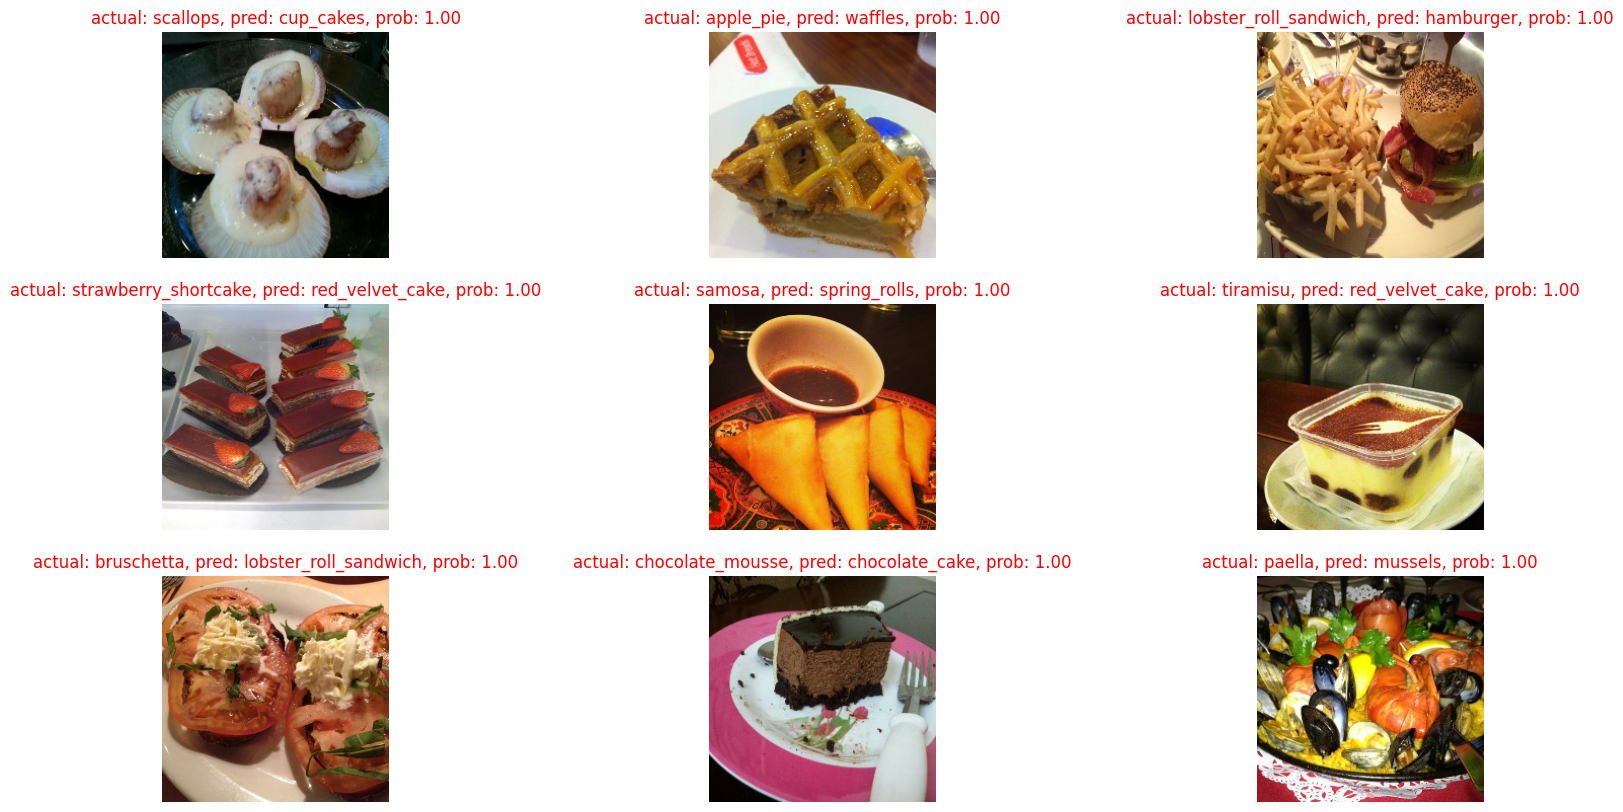

In [ ]:
draw_images_with_true_and_predicted_labels(3, 3, filepaths=wrong_pred_df.head(9).img_path.values,
                                           class_name=wrong_pred_df.head(9).true_class.values)